<a href="https://colab.research.google.com/github/HuyenNguyenHelen/LING-5412/blob/main/Assignment3_LinearModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing libraries that will be used 
import numpy as np
import tarfile
import glob
import re
import pandas as pd
import nltk
nltk.download('wordnet')
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Loading the dataset

In [2]:
!wget http://www.cs.cornell.edu/people/pabo/movie-review-data/scale_data.tar.gz

--2021-10-15 21:47:53--  http://www.cs.cornell.edu/people/pabo/movie-review-data/scale_data.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4029756 (3.8M) [application/x-gzip]
Saving to: ‘scale_data.tar.gz.3’

scale_data.tar.gz.3 100%[===================>]   3.84M  17.8MB/s    in 0.2s    

2021-10-15 21:47:54 (17.8 MB/s) - ‘scale_data.tar.gz.3’ saved [4029756/4029756]



In [3]:
# Untar the dataset
my_tar = tarfile.open('/content/scale_data.tar.gz')
my_tar.extractall('/content/') 
my_tar.close()


In [4]:
# Reformatting the dataset into a single dataframe for our convinience
id, review, rating, cl_3, cl_4 = [],[],[],[], []
for root in glob.glob ('/content/scaledata/*'):
  for path in glob.glob(root+'/*'): 
      fo = open(path)
      doc = fo.read()
      if 'id' in path:
        id.extend(doc.split('\n'))
      elif 'subj' in path:
          review.extend(doc.split('\n'))
      elif 'rating' in path:
        rating.extend(doc.split('\n'))
      elif '3class' in path:
        cl_3.extend(doc.split('\n'))
      else:
        cl_4.extend(doc.split('\n'))

print (len(id), len(review), len(rating), len(cl_3), len(cl_4))
df = pd.DataFrame(zip(id, review, rating, cl_3, cl_4), columns = ['id', 'review', 'rating', '3class', '4class'])


# Using these 2 columns to build a dataset for a 3-class classifier
data = df[['review', '3class']].dropna()
data

# Using these 2 columns to build a dataset for a rating-based regressor
# df = pd.DataFrame(zip(id, review, rating, cl_3, cl_4), columns = ['id', 'review', 'rating', '3class', '4class'])
# new_df = df[['review', 'rating']].dropna()
# new_df = new_df[new_df['rating'] != '']
# new_df['rating'] =new_df['rating'].apply(lambda x: float(x))

5010 5010 5010 5010 5010


,review,3class,4class
0,"in my opinion , a movie reviewer's most import...",0,0
1,"you can watch this movie , that is based on a ...",0,0
2,"this is asking a lot to believe , and though i...",0,0
3,no heroes and no story are the main attributes...,0,0
4,"this is not an art movie , yet i saw it an art...",0,0
...,...,...,...
5005,nicolas roeg's mesmerizing 1971 film walkabout...,2,3
5006,the movie air force one should require a docto...,2,3
5007,""" well , jones , at least you haven't forgotte...",2,3
5008,in a time of bloated productions where special...,2,3


# Pre-processing the data

In [5]:
data['3class'].value_counts()

1    1915
2    1894
0    1197
        4
Name: 3class, dtype: int64

In [6]:
data = data[data['3class']!='']


In [7]:
# Spliting the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split (data['review'], data['3class'] , train_size = 0.8, random_state = 42, shuffle = True, stratify=data['3class'])
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (4004,) (4004,)
Shapes of X_test, y_test:  (1002,) (1002,)


In [8]:
# Vectorizing the documents
vectorizer = CountVectorizer(binary = True)
X_train = vectorizer.fit_transform(X_train.to_list())
X_test = vectorizer.transform(X_test.to_list())
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (4004, 38629) (4004,)
Shapes of X_test, y_test:  (1002, 38629) (1002,)


# Linear models

### Default

In [9]:
def printing_eval_scores (y_true, y_pred, report=''):
  accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
  precision = sklearn.metrics.precision_score(y_true, y_pred, average = 'weighted')
  recall = sklearn.metrics.recall_score(y_true, y_pred, average = 'weighted')
  f1 = sklearn.metrics.f1_score(y_true, y_pred, average = 'weighted')
  print('accuracy score: {:.3f}'.format(accuracy))
  print('precision score: {:.3f}'.format(precision))
  print('recall score: {:.3f}'.format(recall))
  print('F1 score: {:.3f}'.format(f1))
  if report is True:
    print(classification_report(y_true, y_pred))
  else:
    pass
  return accuracy, precision, recall, f1

In [10]:

def training (penalty, max_iter): #penalty="l2", max_iter=100
  SGD = SGDClassifier( penalty=penalty, max_iter=max_iter, shuffle=True).fit(X_train, y_train)
  y_pred = SGD.predict(X_test)
  printing_eval_scores (y_test, y_pred, report=True)

penalties = ['l1','l2']
for penalty in penalties:
  print('\n-------training linear model with penalty = {}'.format(penalty ))
  training (penalty='l2', max_iter=100)


-------training linear model with penalty = l1
accuracy score: 0.657
precision score: 0.658
recall score: 0.657
F1 score: 0.656
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       240
           1       0.59      0.62      0.60       383
           2       0.70      0.75      0.72       379

    accuracy                           0.66      1002
   macro avg       0.66      0.65      0.65      1002
weighted avg       0.66      0.66      0.66      1002


-------training linear model with penalty = l2
accuracy score: 0.656
precision score: 0.660
recall score: 0.656
F1 score: 0.656
              precision    recall  f1-score   support

           0       0.69      0.56      0.62       240
           1       0.58      0.65      0.62       383
           2       0.72      0.72      0.72       379

    accuracy                           0.66      1002
   macro avg       0.66      0.64      0.65      1002
weighted avg       0.66      0.66  

Penalty = L2, and loss = log (logistic regression model) yeild the best performance on F1 score (0.657)

### Searching the best parameter

In [11]:
# Set the parameters by cross-validation
tuned_parameters = [{'alpha': [i for i in np.arange (0.0001, 0.01, 0.001 )]}] #, 'loss': ['log','hinge', 'perceptron']}]
score = 'f1'

print("# Searching hyper-parameters for %s" % score)
clf = GridSearchCV(SGDClassifier(shuffle=True), tuned_parameters, scoring='%s_macro' % score, cv = 5, refit = True, n_jobs = -1 )
clf.fit(X_train, y_train)
print('Best parameters set found on development set: {}'.format(clf.best_params_))
print("Grid scores on development set:")
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

y_pred =  clf.predict(X_test)
printing_eval_scores (y_test, y_pred, report=True)



# Searching hyper-parameters for f1
Best parameters set found on development set: {'alpha': 0.0081}
Grid scores on development set:
accuracy score: 0.653
precision score: 0.652
recall score: 0.653
F1 score: 0.652
              precision    recall  f1-score   support

           0       0.66      0.60      0.63       240
           1       0.58      0.59      0.59       383
           2       0.72      0.74      0.73       379

    accuracy                           0.65      1002
   macro avg       0.65      0.65      0.65      1002
weighted avg       0.65      0.65      0.65      1002



(0.6526946107784432,
 0.6523620595138327,
 0.6526946107784432,
 0.6520933652058369)

**(4)  SGDClassifier used “one versus all” (OVA) strategy to handle multi-class strategy. For each of K classes, the binary classifier will try to predict that class and the rest other K-1 classes.**

In [12]:
# Printing features with highest weights.
best_SGD = SGDClassifier( penalty='l2',  shuffle=True, alpha=0.0081).fit(X_train, y_train)
y_pred = best_SGD.predict(X_test)
weights = best_SGD.coef_
weights

array([[ 0.01401134, -0.03642949, -0.03642949, ...,  0.        ,
        -0.00186818,  0.        ],
       [ 0.04786152, -0.04786152, -0.02109152, ..., -0.01946909,
         0.00730091, -0.01135697],
       [-0.08807268,  0.06781596,  0.05460506, ...,  0.01849526,
         0.00264218,  0.        ]])

In [13]:
features = vectorizer.get_feature_names()

feature_weights = {}
for i in range(len(weights)):
  print('\n==============================================')
  print ('\nclass: {}'.format(i+1))
  for w in range(len(weights[i])):
     feature_weights[features[w]] = np.abs(weights[i][w])
  # Sorting the dictionary in descending order
  sorted_feature_weights = {k:v for k, v in sorted(feature_weights.items(), key = lambda item: item[1], reverse=True)}

  # Print the weights learned for each class
  print('10 most important features (in descending order): ')
  for k, v in list(sorted_feature_weights.items())[:20]:
    print ('{}: {:.5f}'. format(k,v))




class: 1
10 most important features (in descending order): 
bad: 0.29144
boring: 0.26902
awake: 0.25034
ridiculous: 0.24380
suppose: 0.23165
watchable: 0.23165
problems: 0.22418
dull: 0.22138
unfunny: 0.21951
fine: 0.21764
inane: 0.21484
yet: 0.21017
top: 0.20830
failed: 0.20363
routine: 0.19896
worst: 0.19803
although: 0.19709
satisfying: 0.19709
highly: 0.19242
keeps: 0.19149


class: 2
10 most important features (in descending order): 
problems: 0.31151
able: 0.28555
unfortunately: 0.26770
problem: 0.26202
terrific: 0.25959
ve: 0.23850
add: 0.23687
changes: 0.23687
marriage: 0.23687
fits: 0.23363
albeit: 0.23282
leads: 0.23120
nice: 0.22957
myself: 0.22795
thumbs: 0.22552
cute: 0.21822
entertaining: 0.21659
though: 0.21659
cool: 0.21254
mixed: 0.20605


class: 3
10 most important features (in descending order): 
unfortunately: 0.35581
interesting: 0.26862
flat: 0.26158
problem: 0.25453
great: 0.24660
thumbs: 0.24660
predictable: 0.23515
tries: 0.23075
the: 0.22987
traditional: 0.2

**Q6. How does the hyperplane of the classifier look like?**

In [14]:
import seaborn as sns
# sns.displot(weights)
hyperplane = best_SGD.decision_function(X_train).T
#sns.displot(np.flatnonzero(hyperplane))
hyperplane

array([[-1.3595285 , -1.02512442, -2.73544249, ..., -2.86434686,
        -1.37073757, -1.24370138],
       [ 0.9792596 ,  1.0198202 , -1.56470182, ..., -1.08121936,
        -1.06256148, -2.49840704],
       [-1.09774786, -1.05899588,  2.30626116, ...,  1.25907701,
         0.97988662,  1.53210232]])

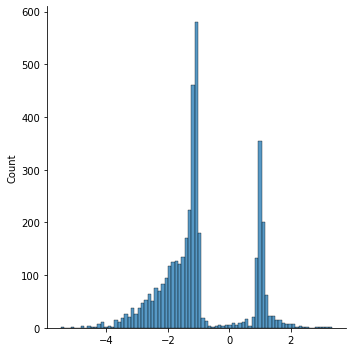

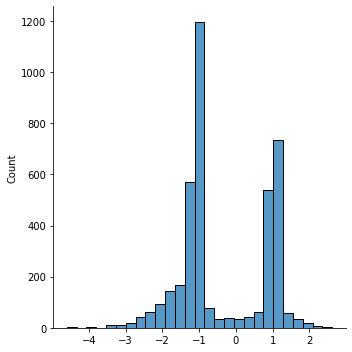

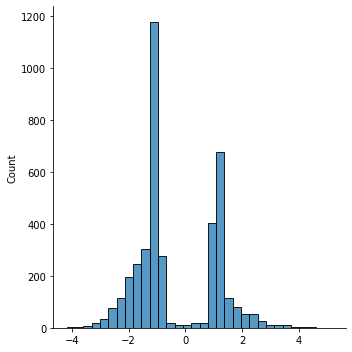

In [15]:
for i in range(3):
  sns.displot(hyperplane[i], kind = 'hist')


**Q7. Model with log loss function**

In [16]:
log_SGD = SGDClassifier(loss='log', penalty='l2',  shuffle=True, alpha=0.0081).fit(X_train, y_train)
y_pred = log_SGD.predict(X_test)
printing_eval_scores (y_test, y_pred, report=True)


accuracy score: 0.661
precision score: 0.674
recall score: 0.661
F1 score: 0.662
              precision    recall  f1-score   support

           0       0.72      0.56      0.63       240
           1       0.57      0.70      0.63       383
           2       0.75      0.69      0.72       379

    accuracy                           0.66      1002
   macro avg       0.68      0.65      0.66      1002
weighted avg       0.67      0.66      0.66      1002



(0.6606786427145709,
 0.6739651297015309,
 0.6606786427145709,
 0.6620314647160789)

**8. Building a linear model to compare the result**

In [17]:
# df = pd.DataFrame(zip(id, review, rating, cl_3, cl_4), columns = ['id', 'review', 'rating', '3class', '4class'])
# new_df = df[['review', 'rating']].dropna()
# new_df = new_df[new_df['rating'] != '']
# new_df['rating'] =new_df['rating'].apply(lambda x: float(x))
     
   

In [18]:
new_df['rating'].describe()

count    5006.000000
mean        0.581422
std         0.181725
min         0.000000
25%         0.490000
50%         0.600000
75%         0.700000
max         1.000000
Name: rating, dtype: float64

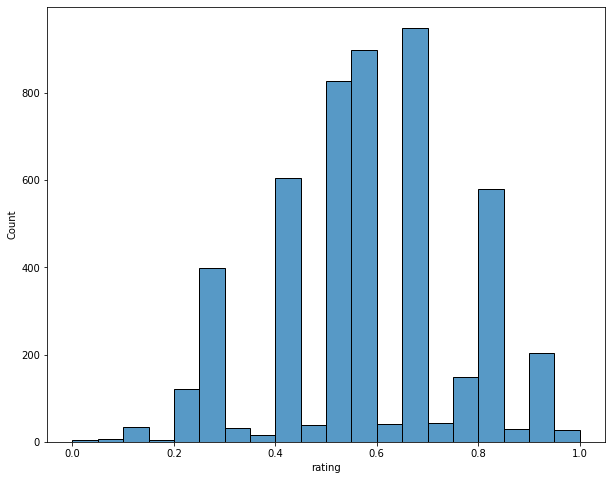

In [19]:
plt.figure(figsize=(10,8))
sns.histplot(data = new_df, x = 'rating', bins = 20)
plt.show()


In [20]:
# Spliting the dataset for training and testing
X_train_, X_test_, y_train_, y_test_ = train_test_split (new_df['review'], new_df['rating'] , train_size = 0.8, random_state = 42, shuffle = True)
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (4004, 38629) (4004,)
Shapes of X_test, y_test:  (1002, 38629) (1002,)


In [21]:
# Vectorizing the documents
vectorizer = CountVectorizer(binary = True)
X_train_ = vectorizer.fit_transform(X_train_.to_list())
X_test_ = vectorizer.transform(X_test_.to_list())
print ('Shapes of X_train, y_train: ', X_train.shape, y_train.shape)
print ('Shapes of X_test, y_test: ', X_test.shape, y_test.shape)

Shapes of X_train, y_train:  (4004, 38629) (4004,)
Shapes of X_test, y_test:  (1002, 38629) (1002,)


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
reg = LinearRegression().fit(X_train_, y_train_)
y_pred = reg.predict(X_test_)
print('mean squared error: {:.3f}'.format(mean_squared_error(y_test_, y_pred)))
print('r2 score: {:.3f}'.format(r2_score(y_test_, y_pred)))

mean squared error: 0.019
r2 score: 0.413


In [23]:
y_pred_cl = []
for i in y_pred:
  if i <=0.4:
    y_pred_cl.append("0")
  elif i >=0.7:
    y_pred_cl.append("2")
  else:
    y_pred_cl.append("1")
printing_eval_scores(y_test, y_pred_cl, report = True)

accuracy score: 0.347
precision score: 0.330
recall score: 0.347
F1 score: 0.315
              precision    recall  f1-score   support

           0       0.22      0.15      0.18       240
           1       0.38      0.63      0.47       383
           2       0.35      0.18      0.24       379

    accuracy                           0.35      1002
   macro avg       0.32      0.32      0.30      1002
weighted avg       0.33      0.35      0.32      1002



(0.3473053892215569,
 0.33029549036644185,
 0.3473053892215569,
 0.31539444137412953)

# Implementing minibatches


In [24]:
from sklearn.linear_model import SGDClassifier
import random
log_SGD_2 = SGDClassifier(loss='log', penalty='l2',  shuffle=True, alpha=0.0081).fit(X_train, y_train)
n_iter = 10
batch_size = 32
for n in range(n_iter):
  print ('----------iteration {}-----------'.format(n+1))
  n_instances, n_features = X_train.shape
  i=0 
  while i<= round(n_instances/batch_size):
    m = batch_size * i
    n = m + batch_size
    log_SGD_2.partial_fit(X_train[m:n], y_train[m:n], classes=np.unique(y_train))
    i+=1    
  y_pred = log_SGD_2.predict(X_test)
  printing_eval_scores(y_test, y_pred, report = True)

----------iteration 1-----------
accuracy score: 0.667
precision score: 0.678
recall score: 0.667
F1 score: 0.666
              precision    recall  f1-score   support

           0       0.76      0.53      0.63       240
           1       0.58      0.68      0.62       383
           2       0.73      0.74      0.73       379

    accuracy                           0.67      1002
   macro avg       0.69      0.65      0.66      1002
weighted avg       0.68      0.67      0.67      1002

----------iteration 2-----------
accuracy score: 0.665
precision score: 0.675
recall score: 0.665
F1 score: 0.664
              precision    recall  f1-score   support

           0       0.75      0.54      0.63       240
           1       0.58      0.67      0.62       383
           2       0.72      0.74      0.73       379

    accuracy                           0.66      1002
   macro avg       0.68      0.65      0.66      1002
weighted avg       0.67      0.66      0.66      1002

----------